In [5]:
from google.colab import userdata
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, f1_score
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random

!pip install kaggle
!pip install google.colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.6 MB/s eta 0:00:00


Declaración variables de entorno

In [6]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

Descargar dataset

In [7]:
!kaggle datasets download -d crawford/emnist
! mkdir EMNIST
! unzip 'emnist.zip' -d EMNIST

Dataset URL: https://www.kaggle.com/datasets/crawford/emnist
License(s): CC0-1.0
 99% 1.23G/1.24G [00:11<00:00, 138MB/s]
100% 1.24G/1.24G [00:11<00:00, 112MB/s]
Archive:  emnist.zip
  inflating: EMNIST/emnist-balanced-mapping.txt  
  inflating: EMNIST/emnist-balanced-test.csv  
  inflating: EMNIST/emnist-balanced-train.csv  
  inflating: EMNIST/emnist-byclass-mapping.txt  
  inflating: EMNIST/emnist-byclass-test.csv  
  inflating: EMNIST/emnist-byclass-train.csv  
  inflating: EMNIST/emnist-bymerge-mapping.txt  
  inflating: EMNIST/emnist-bymerge-test.csv  
  inflating: EMNIST/emnist-bymerge-train.csv  
  inflating: EMNIST/emnist-digits-mapping.txt  
  inflating: EMNIST/emnist-digits-test.csv  
  inflating: EMNIST/emnist-digits-train.csv  
  inflating: EMNIST/emnist-letters-mapping.txt  
  inflating: EMNIST/emnist-letters-test.csv  
  inflating: EMNIST/emnist-letters-train.csv  
  inflating: EMNIST/emnist-mnist-mapping.txt  
  inflating: EMNIST/emnist-mnist-test.csv  
  inflating: EMNI

In [8]:
data = pd.read_csv('/content/EMNIST/emnist-letters-train.csv',header=None)
test_data = pd.read_csv('/content/EMNIST/emnist-letters-test.csv',header=None)
print('Filas y columnas de emnist-letters-train.csv: ',data.shape)
print('Filas y columnas de emnist-letters-test.csv: ',test_data.shape)

Filas y columnas de emnist-letters-train.csv:  (88800, 785)
Filas y columnas de emnist-letters-test.csv:  (14800, 785)


In [9]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(data.values[:,1:], data.values[:,0], test_size=0.2, random_state = 42)
x_test = test_data.values[:,1:] #(14800, 784)
y_test = test_data.values[:,0]  #(14800, 1)
print('Total del set de entrenamiento: ', x_train.shape[0])
print('Total del set de validación: ', x_val.shape[0])
print('Total del set de test : ', x_test.shape[0])

Total del set de entrenamiento:  71040
Total del set de validación:  17760
Total del set de test :  14800


In [10]:
def resize_and_rotate(x):
  image = x.reshape(x.shape[0],28,28).astype('float32')
  image = np.expand_dims(image, axis = -1)
  image = np.fliplr(image)
  image = np.rot90(image, axes=(2,1))
  return image

In [11]:
x_train = resize_and_rotate(x_train)
x_val = resize_and_rotate(x_val)
x_test = resize_and_rotate(x_test)

In [12]:
def read_image_rot(data,label,name):
  fig, axes = plt.subplots(2,5, figsize=(10,5))
  for i, ax in enumerate(axes.flat):
    ax.imshow(data[i],cmap='gray')
    ax.set_title("%c,%d" %(chr(96+label[i]),label[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
  plt.suptitle(name)

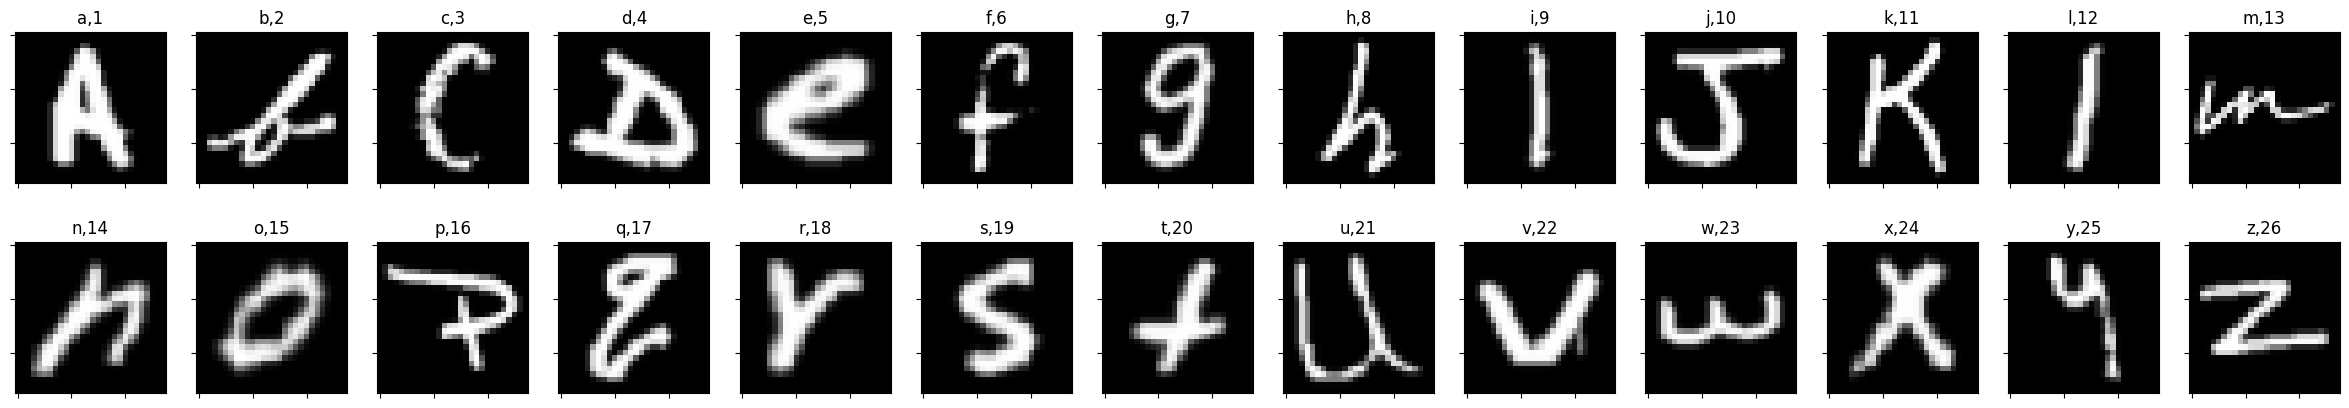

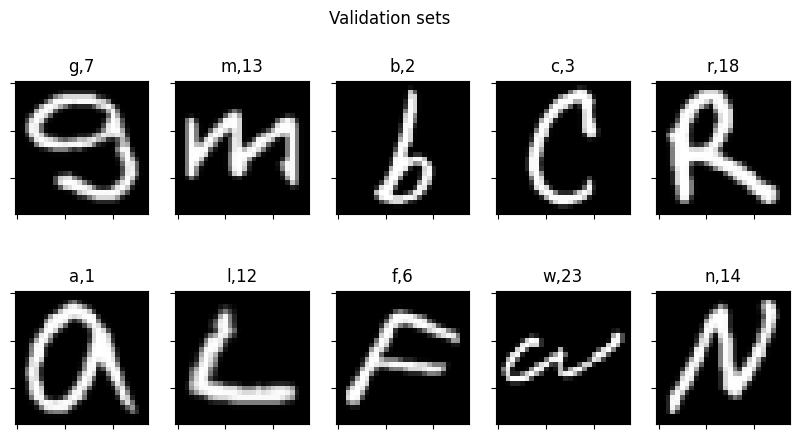

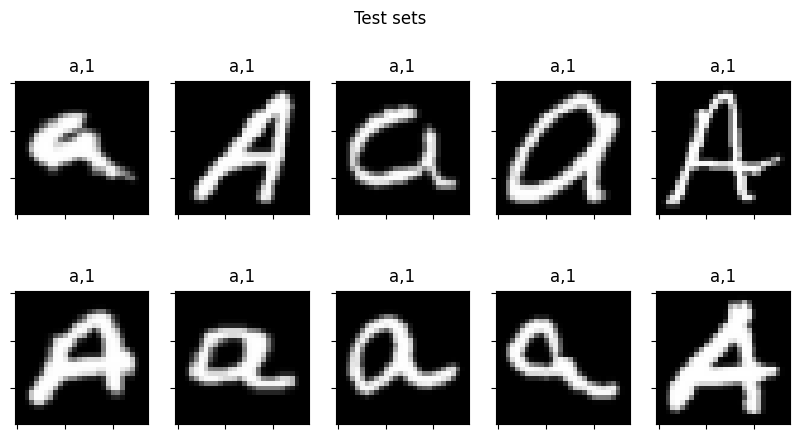

In [13]:
rand = []
for i in np.unique(y_train):
  ind = np.where(y_train == i)[0]
  rand.append(random.choice(ind))

fig, axes = plt.subplots(2,13, figsize = (30,5))
for i, ax in enumerate(axes.flat):
  ax.imshow(x_train[rand[i]], cmap='gray')
  ax.set_title("%c,%d" %(chr(96+y_train[rand[i]]),y_train[rand[i]]))
  ax.set_xticklabels([])
  ax.set_yticklabels([])

# Visualize data of Validation set and Test set
read_image_rot(x_val[:10], y_val[:10],'Validation sets')
read_image_rot(x_test[:10], y_test[:10],'Test sets')

In [14]:
number_of_classes = len(np.unique(y_train))+1
y_train = tf.keras.utils.to_categorical(y_train, number_of_classes)
y_val = tf.keras.utils.to_categorical(y_val, number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, number_of_classes)

Definir cuales son tests y cuales entrenamiento

In [15]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test/ 255.0

**Modelo**

Definición del modelo

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),
    tf.keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu'),
    tf.keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu'),
    tf.keras.layers.Conv2D(128, kernel_size = 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation= 'relu'),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(number_of_classes, activation= 'softmax'),
])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       7,930,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 27)                  │           3,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,092,187 (30.87 MB)

 Trainable params: 8,092,187 (30.87 MB)

 Non-trainable params: 0 (0.00 B)

None


entrenamiento de datos

In [17]:
model.compile(loss = 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, verbose=1)

Epoch 1/50
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.7850 - loss: 0.7056 - val_accuracy: 0.9146 - val_loss: 0.2568
Epoch 2/50
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9348 - loss: 0.1864 - val_accuracy: 0.9302 - val_loss: 0.2115
Epoch 3/50
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9526 - loss: 0.1301 - val_accuracy: 0.9292 - val_loss: 0.2188
Epoch 4/50
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9613 - loss: 0.0989 - val_accuracy: 0.9333 - val_loss: 0.2346
Epoch 5/50
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9665 - loss: 0.0849 - val_accuracy: 0.9331 - val_loss: 0.2494
Epoch 6/50
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9722 - loss: 0.0675 - val_accuracy: 0.9316 - val_loss: 0.2832
Epoch 7/50
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9766 - loss: 0.0584 - val_accuracy: 0.9291 - val_loss: 0.2970
Epoch 8/50
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9767 - loss: 0

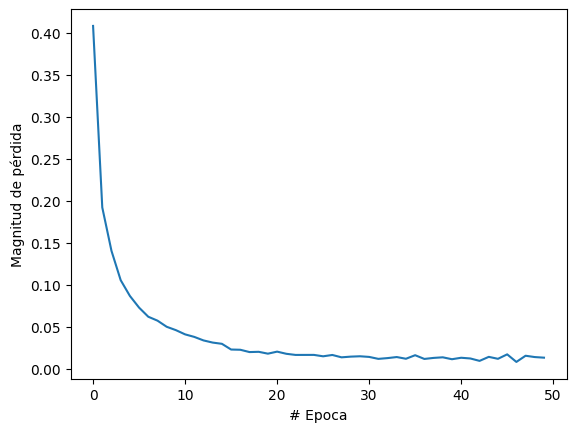

In [18]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(history.history["loss"])

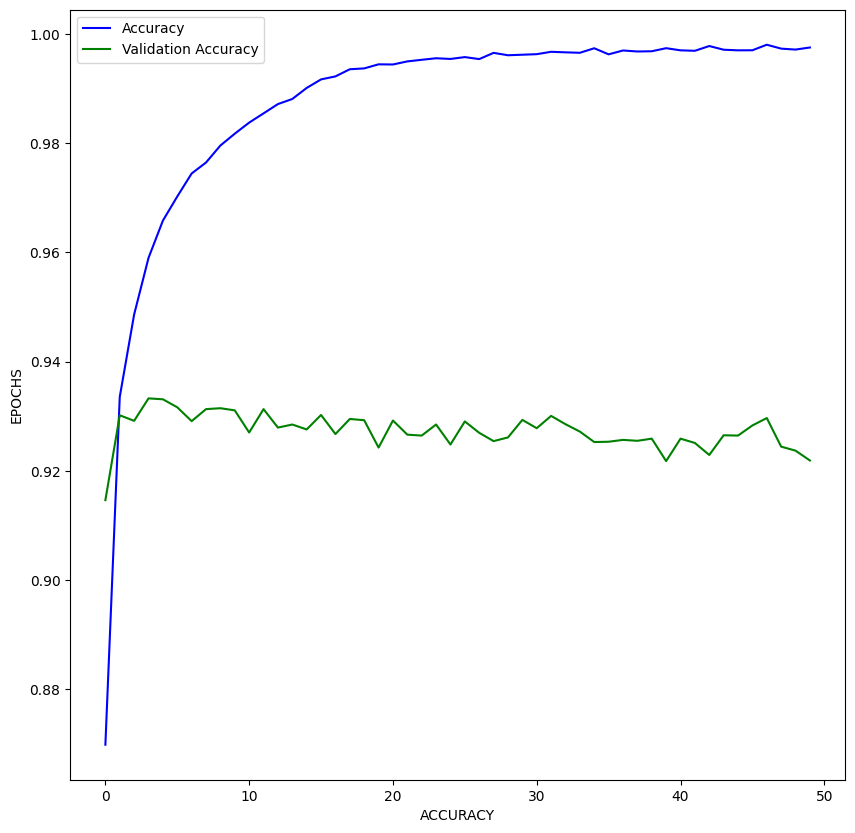

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que ya tienes acc y val_acc
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = range(len(acc))

plt.figure(figsize=(10, 10))
sns.lineplot(x=epoch, y=acc, label='Accuracy', color='blue')  # Cambia 'blue' por el color deseado
sns.lineplot(x=epoch, y=val_acc, label='Validation Accuracy', color='green')  # Cambia 'orange' por el color deseado
plt.ylabel('EPOCHS')
plt.xlabel('ACCURACY')
plt.legend()
plt.show()


463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


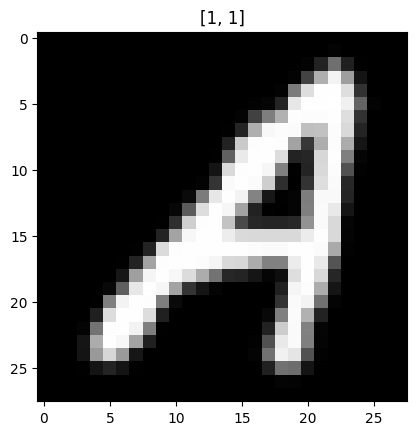

In [26]:
#Test model with the first element of test set
predict = model.predict(x_test)
plt.imshow(x_test[1], cmap='gray')
plt.title([np.argmax(y_test[0]), np.argmax(predict[0])])
plt.show()

Matriz de confusión

F1 score: 0.92%


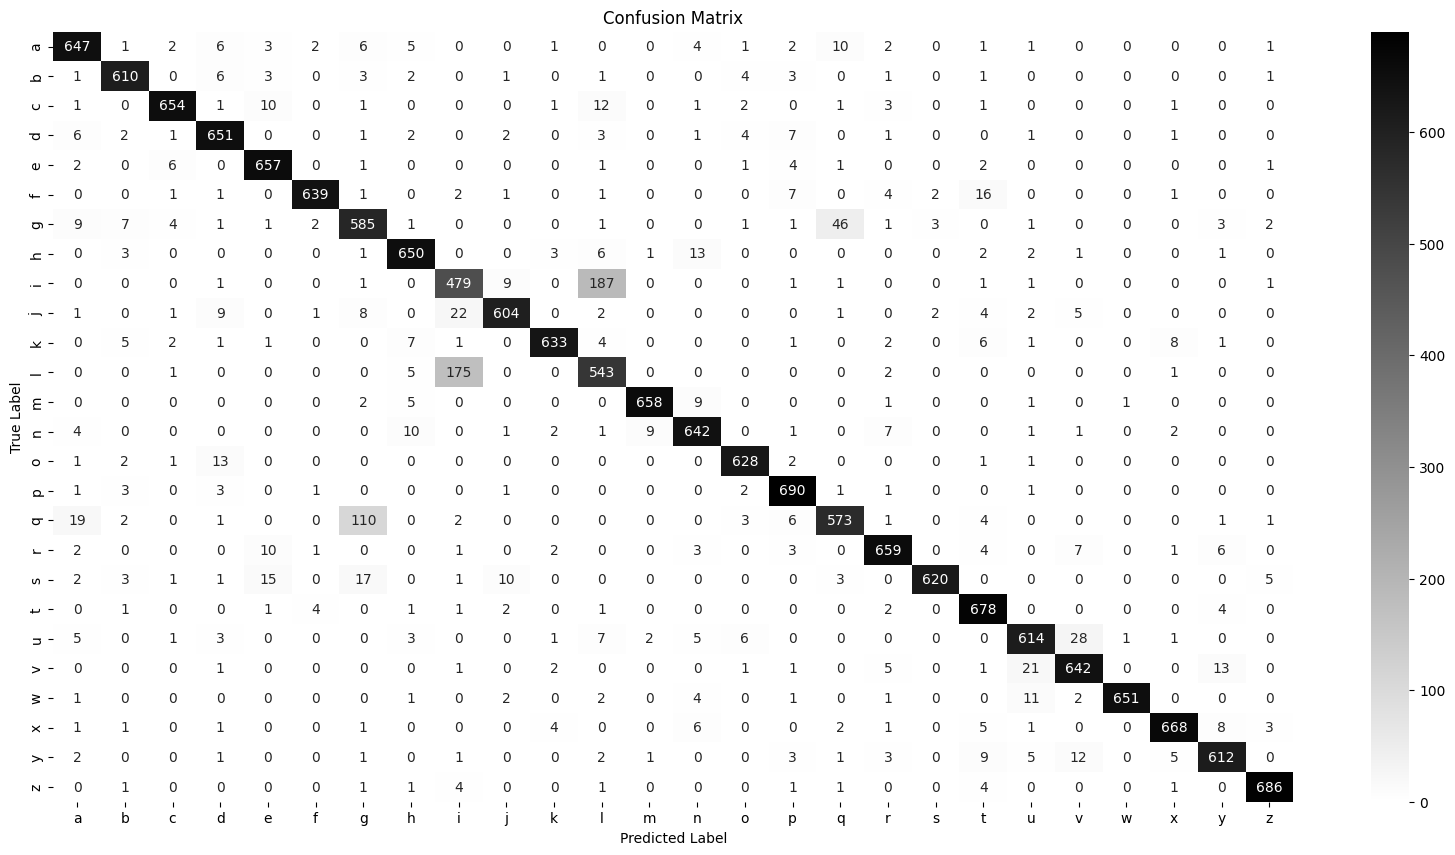

In [27]:
#Display confusion matrix to see the number of true predictions
Y = np.argmax(y_val, axis = 1)
P = np.argmax(model.predict(x_val, verbose = 0), axis = 1)
f1 = f1_score(Y,P, average ='micro')
print("F1 score: %0.2f%%" %f1)
conf_matrix = confusion_matrix(Y, P)
letter = []
for i in range(1,27):
  letter.append(chr(96+i))
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix, annot=True, cmap='binary', fmt= '.0f',xticklabels=letter, yticklabels=letter)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
model.save('numeros_conv.h5')

#Convertirlo a tensorflow.js
!pip install tensorflowjs

!mkdir carpeta_salida

!tensorflowjs_converter --input_format keras numeros_conv.h5 carpeta_salida